<a href="https://colab.research.google.com/github/alexZajac/airlines_performance/blob/master/Starting_kit_twitter.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# LSTM starting kit with sentiment analysis

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.compose import make_column_transformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error, mean_absolute_error


from keras.preprocessing.sequence import TimeseriesGenerator
from keras.models import Sequential
from keras.layers import LSTM, Dense

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.base import RegressorMixin
pd.options.mode.chained_assignment = None  # default='warn'

In [2]:
!gdown "https://drive.google.com/uc?id=1s8NHRN_wAEhCCQXJw9hdvweiUARi0b_t"

Downloading...
From: https://drive.google.com/uc?id=1s8NHRN_wAEhCCQXJw9hdvweiUARi0b_t
To: /mnt/c/Users/alzajac/Desktop/Programmation/Training/airlines_performance/tweets_NLP_dataset_clean.csv
27.8MB [00:08, 3.24MB/s]


In [3]:
%load_ext autotime

time: 643 µs (started: 2021-01-14 23:46:54 +01:00)


In [4]:
CB91_Blue = '#2CBDFE'
CB91_Green = '#47DBCD'
CB91_Pink = '#F3A0F2'
CB91_Purple = '#9D2EC5'
CB91_Violet = '#661D98'
CB91_Amber = '#F5B14C'
color_list = [CB91_Blue, CB91_Pink, CB91_Green, CB91_Amber,
              CB91_Purple, CB91_Violet]
params = {"ytick.color" : "w",
          "xtick.color" : "w",
          'axes.labelsize' : 15,
          "axes.labelcolor" : "w",
          "axes.edgecolor" : "w",
          "axes.titlecolor": "w", 
          'figure.figsize': [20, 8], 
          'axes.prop_cycle': plt.cycler(color=color_list), 
          'figure.dpi' : 75, 
          'legend.fontsize': 10,
          'font.size': 15 
          }
plt.rcParams.update(params)

time: 74 ms (started: 2021-01-14 23:46:54 +01:00)


In [5]:
from problem import get_train_data, get_test_data
X_train, y_train = get_train_data()
max_train_date = max(X_train.features["DATE"])

time: 734 ms (started: 2021-01-14 23:46:54 +01:00)


In [19]:
df_tweets_nlp = pd.read_csv("tweets_NLP_dataset_clean.csv", index_col=0)
df_tweets_nlp['DATE'] = pd.to_datetime(df_tweets_nlp['DATE'])
df_tweets_nlp_train = df_tweets_nlp[df_tweets_nlp["DATE"] <= max_train_date]

time: 840 ms (started: 2021-01-15 00:01:10 +01:00)


## Join both dataframes (tweets with sentiments + main features) 

In [20]:
df_tweets_nlp_train = df_tweets_nlp_train.groupby(['UNIQUE_CARRIER_NAME','DATE'])['NEGATIVE','NEUTRAL','POSITIVE'].mean().reset_index(drop=False)
X_train.features = X_train.features.merge(df_tweets_nlp_train, left_on=['DATE','UNIQUE_CARRIER_NAME'], right_on = ['DATE','UNIQUE_CARRIER_NAME'])
X_train.features.head()

,DATE,UNIQUE_CARRIER_NAME,0,1,2,3,4,5,6,7,...,123,124,125,126,127,128,129,NEGATIVE,NEUTRAL,POSITIVE
0,2013-01-01,Air Wisconsin Airlines Corp,-0.207377,-0.178783,0.0,-0.210729,0.0,-0.17994,-0.210979,-0.148176,...,-0.116424,-0.768924,-0.096012,1.911850,-0.768244,0.747534,-0.136076,0.062290,0.717835,0.219875
1,2013-02-01,Air Wisconsin Airlines Corp,-0.207377,-0.178783,0.0,-0.210729,0.0,-0.17994,-0.210979,-0.148176,...,-0.116424,1.402815,0.050503,2.028029,0.011764,0.641881,-0.785247,0.157656,0.702197,0.140146
2,2013-03-01,Air Wisconsin Airlines Corp,-0.207377,-0.178783,0.0,-0.210729,0.0,-0.17994,-0.210979,-0.148176,...,-0.116424,0.265159,0.077385,1.795671,-0.839882,1.242306,-0.661014,0.053531,0.791065,0.155404
3,2013-04-01,Air Wisconsin Airlines Corp,-0.207377,-0.178783,0.0,-0.210729,0.0,-0.17994,-0.210979,-0.148176,...,-0.116424,0.100577,-0.006427,1.679492,-0.309307,0.714448,-0.553073,0.118401,0.712938,0.168661
4,2013-05-01,Air Wisconsin Airlines Corp,-0.207377,-0.178783,0.0,-0.210729,0.0,-0.17994,-0.210979,-0.148176,...,-0.116424,1.689439,-0.099201,1.563313,-0.172243,-0.394557,0.646951,0.135159,0.548797,0.316044


time: 613 ms (started: 2021-01-15 00:01:16 +01:00)


#### **Step 1** : Create the scaler/transformer classes to transform the data before it will be passed to the model

In [8]:
from sklearn.base import BaseEstimator, TransformerMixin

class CustomStandardScaler(BaseEstimator, TransformerMixin):
    """Wrapper of a standard scaler for out AirlineData data structure"""

    def __init__(self):
        super().__init__()

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        # out features are contained in this attribute
        X_features_mod = X.features.copy()
        scaler = StandardScaler()
        X_features_mod.set_index(['DATE', 'UNIQUE_CARRIER_NAME'], inplace=True)
        idx = X_features_mod.index
        # scling for mean=0 and std=1
        X_features_mod = scaler.fit_transform(X_features_mod)
        X_df = pd.DataFrame(X_features_mod, index=idx)
        X_df.reset_index(level=['DATE', 'UNIQUE_CARRIER_NAME'], inplace=True)
        X.features = X_df
        return X


class CustomLabelEncoder(BaseEstimator, TransformerMixin):
    """Wrapper of a standard scaler for out AirlineData data structure"""
    def __init__(self):
        super().__init__()

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        X_features_mod = X.features
        enc = LabelEncoder()
        for column_name in X_features_mod.columns:
            # transform all non numeric columns except the carrier name
            if X_features_mod[column_name].dtype == object and column_name != 'UNIQUE_CARRIER_NAME':
                X_features_mod[column_name] = enc.fit_transform(
                    X_features_mod[column_name]
                )
        X.features = X_features_mod
        return X

time: 1.62 ms (started: 2021-01-14 23:46:56 +01:00)


#### **Step 2** : Create the LSTM model with 6 layers

In [9]:
num_features = 130
def create_model(win_length):
    model = Sequential()
    model.add(LSTM(64, return_sequences=True, input_shape=(win_length, num_features)))
    model.add(LSTM(128, return_sequences=True))
    model.add(LSTM(256, return_sequences=True))
    model.add(LSTM(128, return_sequences=True))
    model.add(LSTM(64, return_sequences=True))
    model.add(LSTM(num_features, return_sequences=False))
    model.add(Dense(1))

    model.compile(
        loss='mean_squared_error', optimizer='adam', metrics=['mean_squared_error']
    )
    return model

time: 84 ms (started: 2021-01-14 23:46:56 +01:00)


#### **Step 3** : Create the Estimator class

In [10]:
class LSTMRegressor(BaseEstimator, RegressorMixin, TransformerMixin):
    def __init__(self, win_length=2, batch_size=2, n_jobs=1):
        self.n_jobs = n_jobs
        self.win_length = win_length
        self.batch_size = batch_size
        self.model = {}

    def fit(self, X, y):
        X_features = X.features
        carriers = np.unique(X_features['UNIQUE_CARRIER_NAME'])

        for carrier in carriers:
            # subsetting for the current carrier
            X_used = X_features[X_features['UNIQUE_CARRIER_NAME']
                                == carrier].copy()
            X_used.drop(columns=['DATE', 'UNIQUE_CARRIER_NAME'], inplace=True)
            # finding the 
            y_used = y[np.where(
                X_features['UNIQUE_CARRIER_NAME'] == carrier)[0]]
            train_generator = TimeseriesGenerator(
                X_used, y_used, length=self.win_length, sampling_rate=1, batch_size=self.batch_size)
            self.model[carrier] = create_model(self.win_length)
            self.model[carrier].fit(
                train_generator, epochs=20, shuffle=False, verbose=0
            )
        return self

    def predict(self, X):
        X_features = X.features
        carriers = np.unique(X_features['UNIQUE_CARRIER_NAME'])
        predictions = pd.DataFrame(columns=['UNIQUE_CARRIER_NAME', 'PRED'])
        for carrier in carriers:
            X_used = X_features[X_features['UNIQUE_CARRIER_NAME']
                                == carrier].copy()
            y_pred_sub = pd.DataFrame(X_features[X_features['UNIQUE_CARRIER_NAME'] == carrier]['UNIQUE_CARRIER_NAME'], columns=[
                                      'UNIQUE_CARRIER_NAME', 'PRED'])
            y_pred_sub['PRED'] = 0
            X_used.drop(columns=['DATE', 'UNIQUE_CARRIER_NAME'], inplace=True)
            y = np.zeros(X_used.shape[0])
            test_generator = TimeseriesGenerator(
                X_used, y, length=self.win_length, sampling_rate=1, batch_size=self.batch_size)
            predictions_tmp = self.model.get(carrier).predict(test_generator)
            y_pred_sub['PRED'][self.win_length:] = predictions_tmp.reshape(-1)
            predictions = predictions.append(y_pred_sub)
        return predictions['PRED'].to_numpy()

time: 127 ms (started: 2021-01-14 23:46:56 +01:00)


#### **Step 4** : Create the pipeline

In [11]:
def get_estimator():
    label_encoder = CustomLabelEncoder()
    scaler = CustomStandardScaler()
    model = LSTMRegressor()

    # just create the pipeline
    pipeline = Pipeline([
        ('label_encoder', label_encoder),
        ('standard_scaler', scaler),
        ('model', model)
        # inverse scaler
    ], verbose=False)
    return pipeline

time: 195 ms (started: 2021-01-14 23:46:56 +01:00)


#### **Step 5** : Test & see the score

In [12]:
pipeline = get_estimator()
pipeline.fit(X_train, y_train)

Pipeline(steps=[('label_encoder', CustomLabelEncoder()),
                ('standard_scaler', CustomStandardScaler()),
                ('model', LSTMRegressor())])

time: 10min 41s (started: 2021-01-14 23:47:01 +01:00)


In [22]:
X_test, y_test = get_test_data()
max_test_date = max(X_test.features["DATE"])
df_tweets_nlp_test = df_tweets_nlp[df_tweets_nlp["DATE"] <= max_test_date]
df_tweets_nlp_test = df_tweets_nlp_test.groupby(['UNIQUE_CARRIER_NAME','DATE'])['NEGATIVE','NEUTRAL','POSITIVE'].mean().reset_index(drop=False)
X_test.features = X_test.features.merge(df_tweets_nlp_test, left_on=['DATE','UNIQUE_CARRIER_NAME'], right_on = ['DATE','UNIQUE_CARRIER_NAME'])

time: 1.04 s (started: 2021-01-15 00:08:20 +01:00)


In [23]:
y_pred = pipeline.predict(X_test)

time: 10min 42s (started: 2021-01-15 00:08:25 +01:00)


In [24]:
from problem import RMSE, MAE

rmse_score_lstm = RMSE()(y_test, y_pred)
mae_score_lstm  = MAE()(y_test, y_pred)
print(f"RMSE among companies: {rmse_score_lstm }")
print(f"MAE among companies: {mae_score_lstm }")

RMSE among companies: 0.1573586234290747
MAE among companies: 0.0939158507455051
time: 22.2 ms (started: 2021-01-15 00:19:07 +01:00)


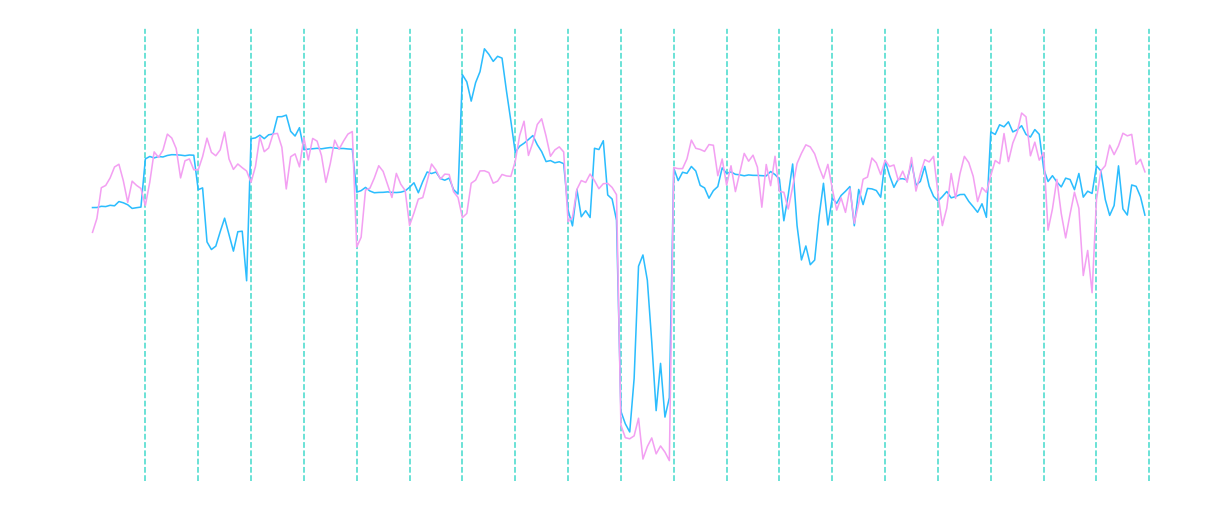

time: 528 ms (started: 2021-01-15 00:22:34 +01:00)


In [27]:
y_pred_plot = []
y_test_plot = []
for c in np.unique(X_test.features["UNIQUE_CARRIER_NAME"] ):
  y_test_plot.extend(y_test[np.where(X_test.features["UNIQUE_CARRIER_NAME"] == c)][-12:])
  y_pred_plot.extend(y_pred[np.where(X_test.features["UNIQUE_CARRIER_NAME"] == c)][-12:])

fig, ax = plt.subplots()
for i in range(1,21):
  ax.axvline(x=12*i, color = '#47DBCD', linestyle = "--")
ax.plot( y_pred_plot, label='True Load Factor')
ax.plot( y_test_plot, label='Predicted Load Factor')
ax.set_title('Predictions for all of the carriers')
ax.patch.set_alpha(0)
plt.show()